### Tasks

#### figure out a way to make the model deeper 
#### consider small model as low rank representation and project higher. (using outer product) train only small number of outer product parameters - https://arxiv.org/pdf/2012.13255.pdf

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [2]:
#Link to dataset: https://archive.ics.uci.edu/ml/datasets/DeliciousMIL%3A+A+Data+Set+for+Multi-Label+Multi-Instance+Learning+with+Instance+Labels#
import numpy as np
import pandas as pd
import re

def createDataset(path):
    file = open(path, "r")
    dataset = []
    split = file.read().splitlines()
 
    for i, line in enumerate(split):
        row = line.split(" ")
        while "" in row:
            row.remove("")
        for i, item in enumerate(row): 
            try:
                row[i] = float(item.split(":")[1])
            except:
                row[i] = int(item)
        dataset.append(row)

    return dataset


In [3]:
dataset = pd.DataFrame(createDataset('Data/covtype.libsvm.binary.scale/covtype.libsvm.binary.scale'))
dataset.drop(columns=[11,12], inplace=True)
dataset.dropna(inplace=True)

In [4]:
dataset

,0,1,2,3,4,5,6,7,8,9,10
0,1,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366
1,1,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838
2,2,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339
3,2,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886
4,1,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449
...,...,...,...,...,...,...,...,...,...,...,...
581007,1,0.268634,0.425000,0.303030,0.060845,0.245478,0.015175,0.944882,0.933071,0.464567,0.116688
581008,1,0.266133,0.422222,0.287879,0.047960,0.239018,0.013348,0.944882,0.933071,0.468504,0.117803
581009,1,0.263632,0.441667,0.257576,0.042949,0.232558,0.012646,0.929134,0.948819,0.511811,0.119058
581010,1,0.262631,0.472222,0.227273,0.042949,0.229974,0.012646,0.905512,0.964567,0.562992,0.120452


In [5]:
class covtype(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  

X_train, X_valid, y_train, y_valid = \
    train_test_split(dataset.loc[:, 1:], dataset.loc[:, 0], test_size=1/6, random_state=42)

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_valid)

y_train_proc = y_train - min(min(y_train), min(y_valid))
y_valid_proc = y_valid - min(min(y_train), min(y_valid))

X_train, y_train = np.array(X_train), np.array(y_train_proc)
X_valid, y_valid = np.array(X_valid), np.array(y_valid_proc)


print('X train shape : ', X_train.shape)
print('y train label shape : ', y_train.shape)
print('X valid  shape : ', X_valid.shape)
print('y valid shape: ', y_valid.shape)

X train shape :  (484100, 10)
y train label shape :  (484100,)
X valid  shape :  (96820, 10)
y valid shape:  (96820,)


In [7]:
train_dataset = covtype(X=X_train, y=y_train)
val_dataset = covtype(X=X_valid, y=y_valid)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [8]:
dataiter = iter(train_loader)
sentences, labels = next(dataiter)

print('sentences shape on PyTorch : ', sentences.size())
print('labels shape on PyTorch : ', labels.size())

sentences shape on PyTorch :  torch.Size([128, 10])
labels shape on PyTorch :  torch.Size([128])


In [14]:
from livelossplot import PlotLosses
device = torch.device("cuda")

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader,
                name):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  best_accuracy = 0 
  liveloss = PlotLosses()

  # Main for loop of SGD.
  for epoch in range(0, n_epochs):
    logs = {}

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in training mode.
    model.train()

    # Sample a batch on each iteration.
    for (batch_id, (xb, yb)) in enumerate(train_loader):
      model.zero_grad()
      # Move (x,y) data to GPU (if so desired).
      xb = xb.to(device)
      yb = yb.to(device)

      # Compute predictions.
      #print("debug", xb.shape, yb.shape)#, predicted.shape)
      predicted = model(xb.float()).squeeze()
      
    
      # Compute loss.
      loss = cost_function(predicted, yb.float())
      cumulative_loss += loss.item()
        
      # Count how many correct in batch.
      predicted_ = predicted.detach().sigmoid()
      predicted_ = torch.round(predicted_)
      correct += (predicted_ == yb).sum().cpu().item()
      n_samples += xb.size(0)

      # Compute gradients (autograd).
      loss.backward()

      # Run one basic training step of SGD.
      optimizer.step()
      # This does basically the following operation.
      # for param in model.parameters():
      #    param.data -= learningRate * param.grad.data

      # Keep track of loss and accuracy for the plot.
      n_batches = 1 + batch_id 
      logs['loss'] = cumulative_loss / n_batches
      logs['accuracy'] = correct / n_samples
    
    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in evaluation mode.
    model.eval()

    # No need to keep track of gradients for this part.
    with torch.no_grad():
      # Run the model on the validation set to keep track of accuracy there.
      for (batch_id, (xb, yb)) in enumerate(val_loader):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)
    
        # Compute predictions.
        predicted = model(xb.float()).squeeze()

        # Compute loss.
        loss = cost_function(predicted, yb.float())
        cumulative_loss += loss.item()

        # Count how many correct in batch.
        predicted_ = predicted.detach().sigmoid()
        predicted_ = torch.round(predicted_)
        correct += (predicted_ == yb).sum().cpu().item()
        n_samples += xb.size(0)

        # Keep track of loss and accuracy for the plot.
        n_batches = 1 + batch_id
        logs['val_loss'] = cumulative_loss / n_batches
        logs['val_accuracy'] = correct / n_samples

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'checkpoints/best_model_so_far_' + name + '.pth')

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()

    # What is this for? Please look it up.
    if scheduler != -1:
        scheduler.step()

  # Load the model parameters for the one that achieved the best val accuracy.
  # model.load_state_dict(torch.load('best_model_so_far.pth'))    

### Check the performance of small-sized model

In [15]:
class MLPSmall(nn.Module):
    def __init__(self):
        super(MLPSmall, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [16]:
learningRate = 1e-4
modelSmall = MLPSmall()
optimizer = torch.optim.Adam(modelSmall.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(modelSmall)

MLPSmall(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


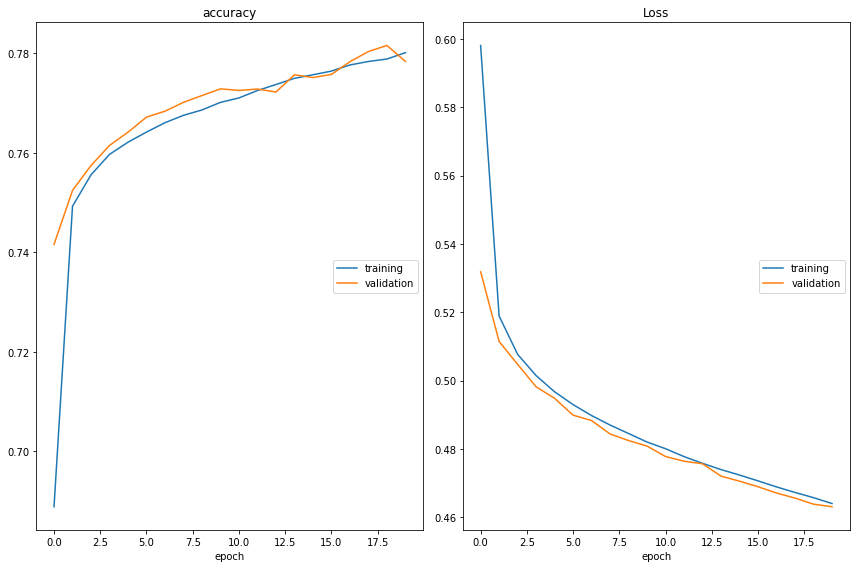

accuracy
	training         	 (min:    0.689, max:    0.780, cur:    0.780)
	validation       	 (min:    0.742, max:    0.782, cur:    0.778)
Loss
	training         	 (min:    0.464, max:    0.598, cur:    0.464)
	validation       	 (min:    0.463, max:    0.532, cur:    0.463)


In [17]:
train_model(batch_size, n_epochs, learningRate, 
            modelSmall, cost_function, optimizer, -1, 
            train_loader, val_loader, name = 'small');

### Check the performance of medium-sized model

In [18]:
class MLPMedium(nn.Module):
    def __init__(self):
        super(MLPMedium, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [20]:
learningRate = 1e-4
modelMedium = MLPMedium()
optimizer = torch.optim.Adam(modelMedium.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(modelMedium)

MLPMedium(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


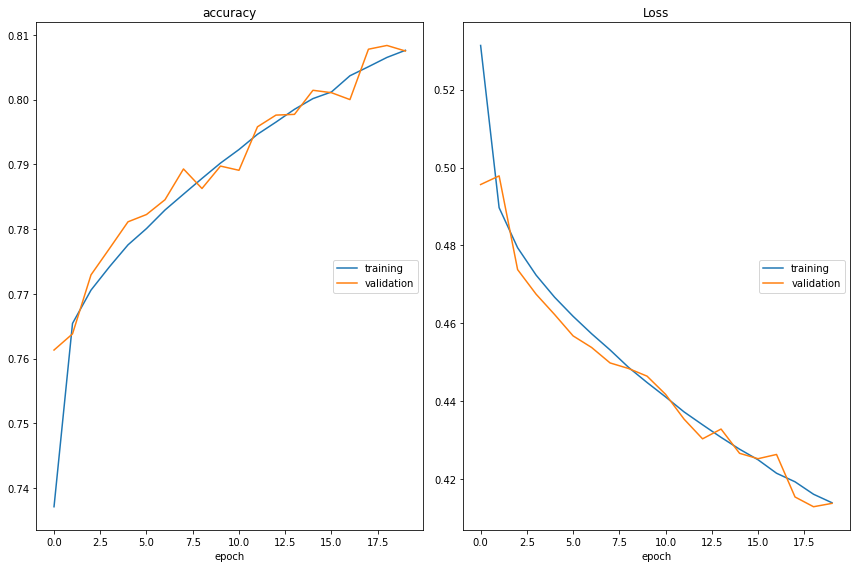

accuracy
	training         	 (min:    0.737, max:    0.808, cur:    0.808)
	validation       	 (min:    0.761, max:    0.808, cur:    0.807)
Loss
	training         	 (min:    0.414, max:    0.531, cur:    0.414)
	validation       	 (min:    0.413, max:    0.498, cur:    0.414)


In [21]:
train_model(batch_size, n_epochs, learningRate, 
            modelMedium, cost_function, optimizer, -1, 
            train_loader, val_loader, name = 'medium');

### Densify small model to the same parameters as the medium model

In [22]:
from scipy.stats import ortho_group
class MLPSmalltoMedium(nn.Module):
    def __init__(self, modelSmall):
        super(MLPSmalltoMedium, self).__init__()
        # extract weights from modelSmall
        self.layers = nn.Sequential(
            nn.Linear(10, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        for layer in range(len(modelSmall.layers)):
            try:
                tempWeight =  modelSmall.layers[layer].weight.data
                if layer != len(modelSmall.layers) - 1:
                    left = torch.tensor(np.delete(ortho_group.rvs(self.layers[layer].out_features), np.s_[modelSmall.layers[layer].out_features:], 1), device=device, dtype=torch.float32)
#                     print("left: " + str(left.size()), "current: " + str(tempWeight.size()))
                    tempWeight = torch.matmul(left, tempWeight)
                if layer != 0:
                    right = torch.tensor(np.delete(ortho_group.rvs(self.layers[layer].in_features), np.s_[modelSmall.layers[layer].in_features:], 1), device=device, dtype=torch.float32)
#                     print("current: " + str(tempWeight.size()), "right: " + str(right.T.size()))
                    tempWeight = torch.matmul(tempWeight, right.T)
                
                self.layers[layer].weight.data = tempWeight
                
            
            except Exception as e:
                print("Layer " + str(layer) + ": " + str(e))
                
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [23]:
bestSmallModel = MLPSmall()
bestSmallModel.load_state_dict(torch.load('checkpoints/best_model_so_far_small.pth'))
bestSmallModel = bestSmallModel.to(device)
upscaledModel = MLPSmalltoMedium(bestSmallModel)

Layer 1: 'ReLU' object has no attribute 'weight'
Layer 3: 'ReLU' object has no attribute 'weight'


In [24]:
learningRate = 1e-4
optimizer = torch.optim.Adam(upscaledModel.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(upscaledModel)

MLPSmalltoMedium(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


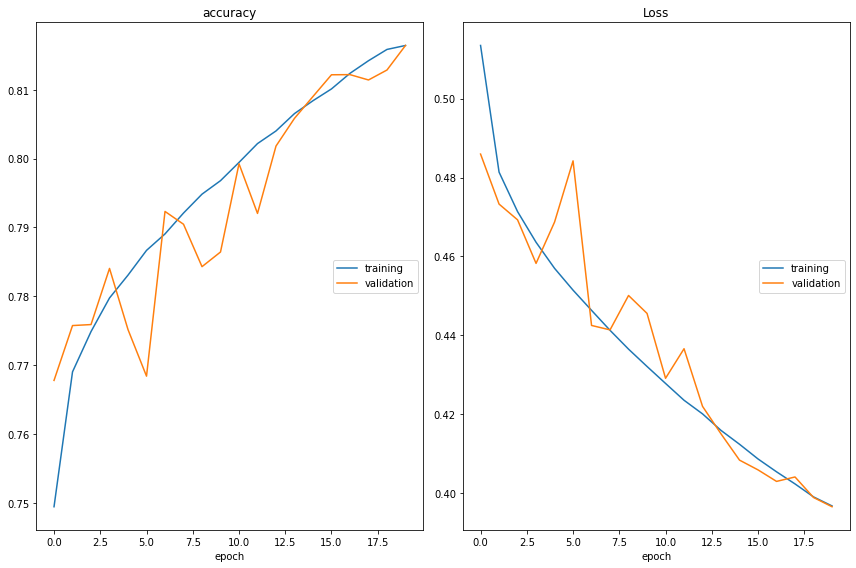

accuracy
	training         	 (min:    0.749, max:    0.816, cur:    0.816)
	validation       	 (min:    0.768, max:    0.816, cur:    0.816)
Loss
	training         	 (min:    0.397, max:    0.513, cur:    0.397)
	validation       	 (min:    0.397, max:    0.486, cur:    0.397)


In [25]:
train_model(batch_size, n_epochs, learningRate, 
            upscaledModel, cost_function, optimizer, -1, 
            train_loader, val_loader, name = "upscaled");

#### Small
accuracy
	training         	 (min:    0.689, max:    0.780, cur:    0.780)
	validation       	 (min:    0.742, max:    0.782, cur:    0.778)
Loss
	training         	 (min:    0.464, max:    0.598, cur:    0.464)
	validation       	 (min:    0.463, max:    0.532, cur:    0.463)
    
#### Medium
accuracy
	training         	 (min:    0.737, max:    0.808, cur:    0.808)
	validation       	 (min:    0.761, max:    0.808, cur:    0.807)
Loss
	training         	 (min:    0.414, max:    0.531, cur:    0.414)
	validation       	 (min:    0.413, max:    0.498, cur:    0.414)

#### Upscaled
accuracy
	training         	 (min:    0.749, max:    0.816, cur:    0.816)
	validation       	 (min:    0.768, max:    0.816, cur:    0.816)
Loss
	training         	 (min:    0.397, max:    0.513, cur:    0.397)
	validation       	 (min:    0.397, max:    0.486, cur:    0.397)